<a href="https://colab.research.google.com/github/Fa-ire/CartSystem/blob/main/Retinal_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from skimage import filters, morphology, measure, segmentation, color, exposure
from skimage.feature import peak_local_max
from skimage.morphology import disk, remove_small_objects
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
%matplotlib inline

In [18]:
data_dir  = "/content/drive/MyDrive/DataScience_RetinalImage_Segmentation/Dataset/TJDR/train/image"

In [19]:
image_files = sorted([f for f in os.listdir(data_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
print(f"Found {len(image_files)} retinal images")
print("\nFirst 10 images:")
for img_file in image_files[:10]:
    print(f"  - {img_file}")

Found 123 retinal images

First 10 images:
  - TJDR_train_001.png
  - TJDR_train_003.png
  - TJDR_train_013.png
  - TJDR_train_017.png
  - TJDR_train_021.png
  - TJDR_train_023.png
  - TJDR_train_032.png
  - TJDR_train_035.png
  - TJDR_train_048.png
  - TJDR_train_049.png


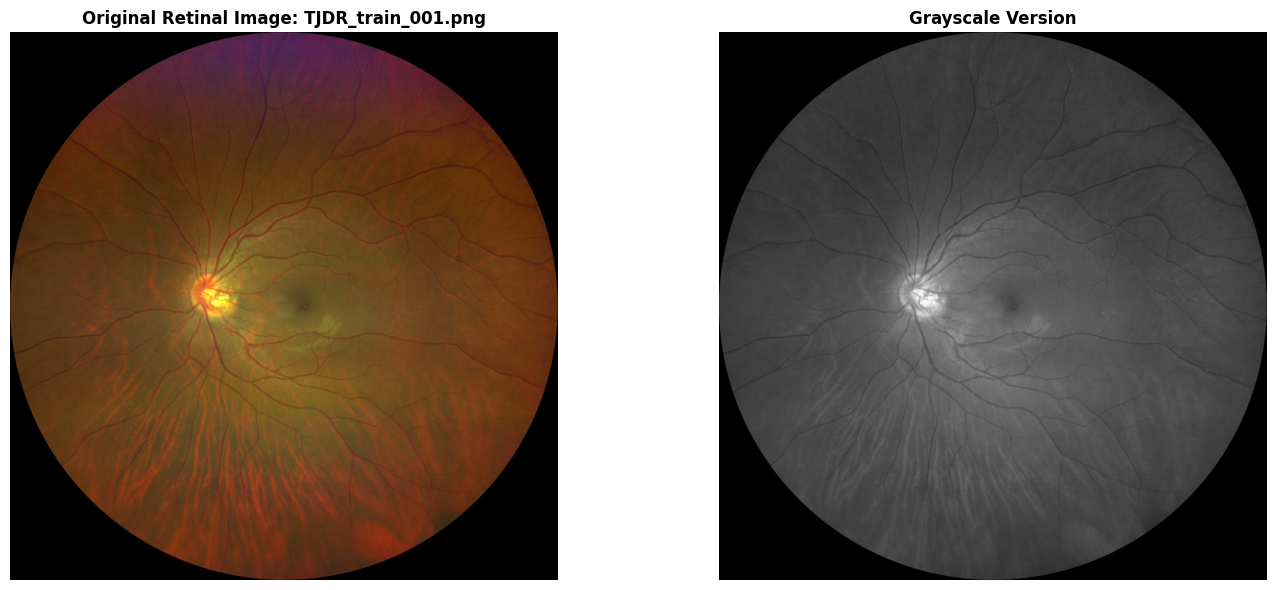

Image shape: (3912, 3912, 3)
Image dtype: uint8


In [20]:
def load_retinal_image(image_path):
    """Load and preprocess a retinal fundus image"""
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")

    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to grayscale for processing
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img_rgb, img_gray

def enhance_contrast(img):
    """Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)"""
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(img)
    return enhanced

# Load a sample image for demonstration
sample_image_path = Path(data_dir) / image_files[0]
sample_rgb, sample_gray = load_retinal_image(sample_image_path)

# Display the original image
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].imshow(sample_rgb)
axes[0].set_title(f"Original Retinal Image: {image_files[0]}", fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(sample_gray, cmap='gray')
axes[1].set_title("Grayscale Version", fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Image shape: {sample_rgb.shape}")
print(f"Image dtype: {sample_rgb.dtype}")

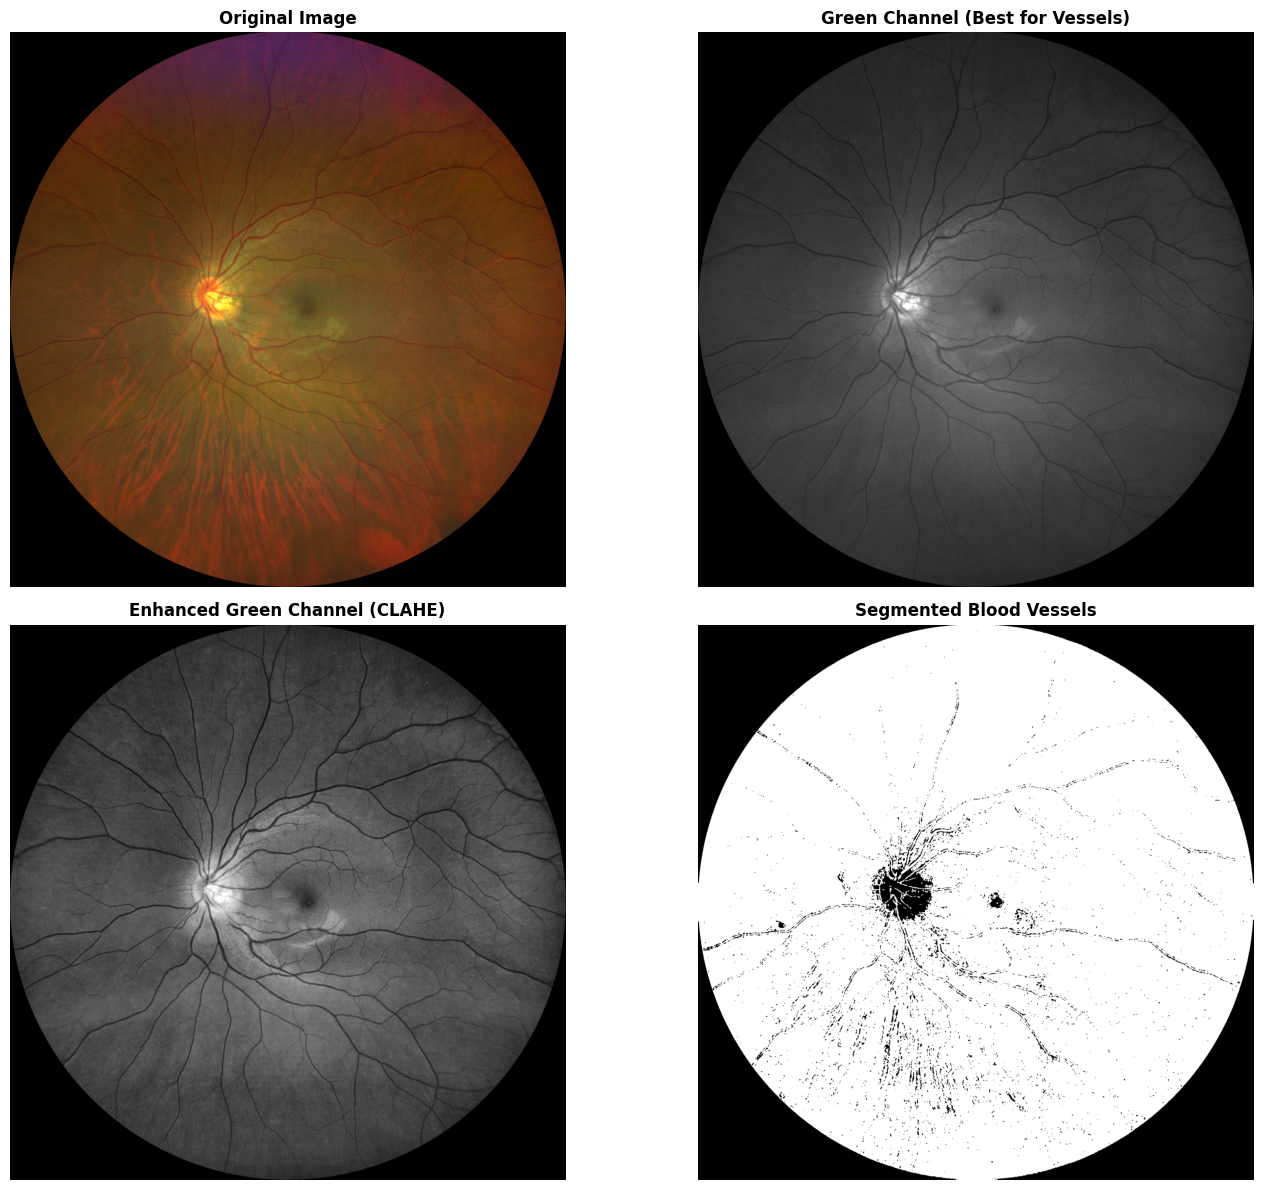

In [21]:
def load_retinal_image(image_path):
    """Load and preprocess a retinal fundus image"""
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")

    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to grayscale for processing
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img_rgb, img_gray

# Ensure `data_dir`, `image_files`, and `Path` are available for `sample_image_path`
# These are typically defined in earlier cells, but included here for robustness.
from pathlib import Path
# Assuming data_dir and image_files are defined in preceding cells
# data_dir = "/content/drive/MyDrive/Data science/Data Segmentation/retinal data set"
# image_files = sorted([f for f in os.listdir(data_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

sample_image_path = Path(data_dir) / image_files[0]
sample_rgb, sample_gray = load_retinal_image(sample_image_path)

def extract_green_channel(img_rgb):
    """Extract green channel - best for vessel visualization"""
    return img_rgb[:, :, 1]

def segment_vessels_frangi(img_gray, sigma_range=(1, 3), num_sigmas=5):
    """Segment blood vessels using Frangi vesselness filter"""
    from scipy import ndimage

    # Apply Frangi filter at multiple scales
    vesselness = np.zeros_like(img_gray, dtype=np.float64)

    sigmas = np.linspace(sigma_range[0], sigma_range[1], num_sigmas)

    for sigma in sigmas:
        # Gaussian smoothing
        smoothed = filters.gaussian(img_gray, sigma=sigma)

        # Compute Hessian matrix components
        hxx = filters.gaussian(smoothed, sigma=sigma, order=(2, 0))
        hyy = filters.gaussian(smoothed, sigma=sigma, order=(0, 2))
        hxy = filters.gaussian(smoothed, sigma=sigma, order=(1, 1))

        # Compute eigenvalues
        lambda1 = 0.5 * (hxx + hyy + np.sqrt((hxx - hyy)**2 + 4 * hxy**2))
        lambda2 = 0.5 * (hxx + hyy - np.sqrt((hxx + hyy)**2 - 4 * (hxx*hyy - hxy**2)))

        # Vesselness measure (simplified)
        beta = 0.5
        c = 0.5 * np.max(lambda1)
        vesselness_sigma = np.exp(-(lambda1**2) / (2 * beta**2)) * (1 - np.exp(-(lambda2**2) / (2 * c**2)))
        vesselness_sigma[lambda2 > 0] = 0

        vesselness = np.maximum(vesselness, vesselness_sigma)

    return vesselness

def enhance_contrast(img):
    """Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)"""
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(img)
    return enhanced

def segment_vessels_morphological(img_gray):
    """Segment vessels using morphological operations"""
    # Extract green channel if RGB
    if len(img_gray.shape) == 3:
        img_gray = extract_green_channel(img_gray)

    # Enhance contrast
    enhanced = enhance_contrast(img_gray)

    # Apply top-hat transform to enhance vessels
    kernel = morphology.disk(5)
    tophat = morphology.white_tophat(enhanced, kernel)

    # Apply bottom-hat transform
    bothat = morphology.black_tophat(enhanced, kernel)

    # Combine
    vessels = tophat + bothat

    # Threshold
    threshold = filters.threshold_otsu(vessels)
    binary_vessels = vessels > threshold

    # Clean up using morphological operations
    binary_vessels = morphology.remove_small_objects(binary_vessels, min_size=50)
    binary_vessels = morphology.binary_closing(binary_vessels, morphology.disk(2))

    return binary_vessels.astype(np.uint8) * 255

# Segment vessels using different methods
green_channel = extract_green_channel(sample_rgb)
enhanced_green = enhance_contrast(green_channel)
vessels_morph = segment_vessels_morphological(sample_gray)

# Display results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].imshow(sample_rgb)
axes[0, 0].set_title("Original Image", fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(green_channel, cmap='gray')
axes[0, 1].set_title("Green Channel (Best for Vessels)", fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[1, 0].imshow(enhanced_green, cmap='gray')
axes[1, 0].set_title("Enhanced Green Channel (CLAHE)", fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(vessels_morph, cmap='gray')
axes[1, 1].set_title("Segmented Blood Vessels", fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

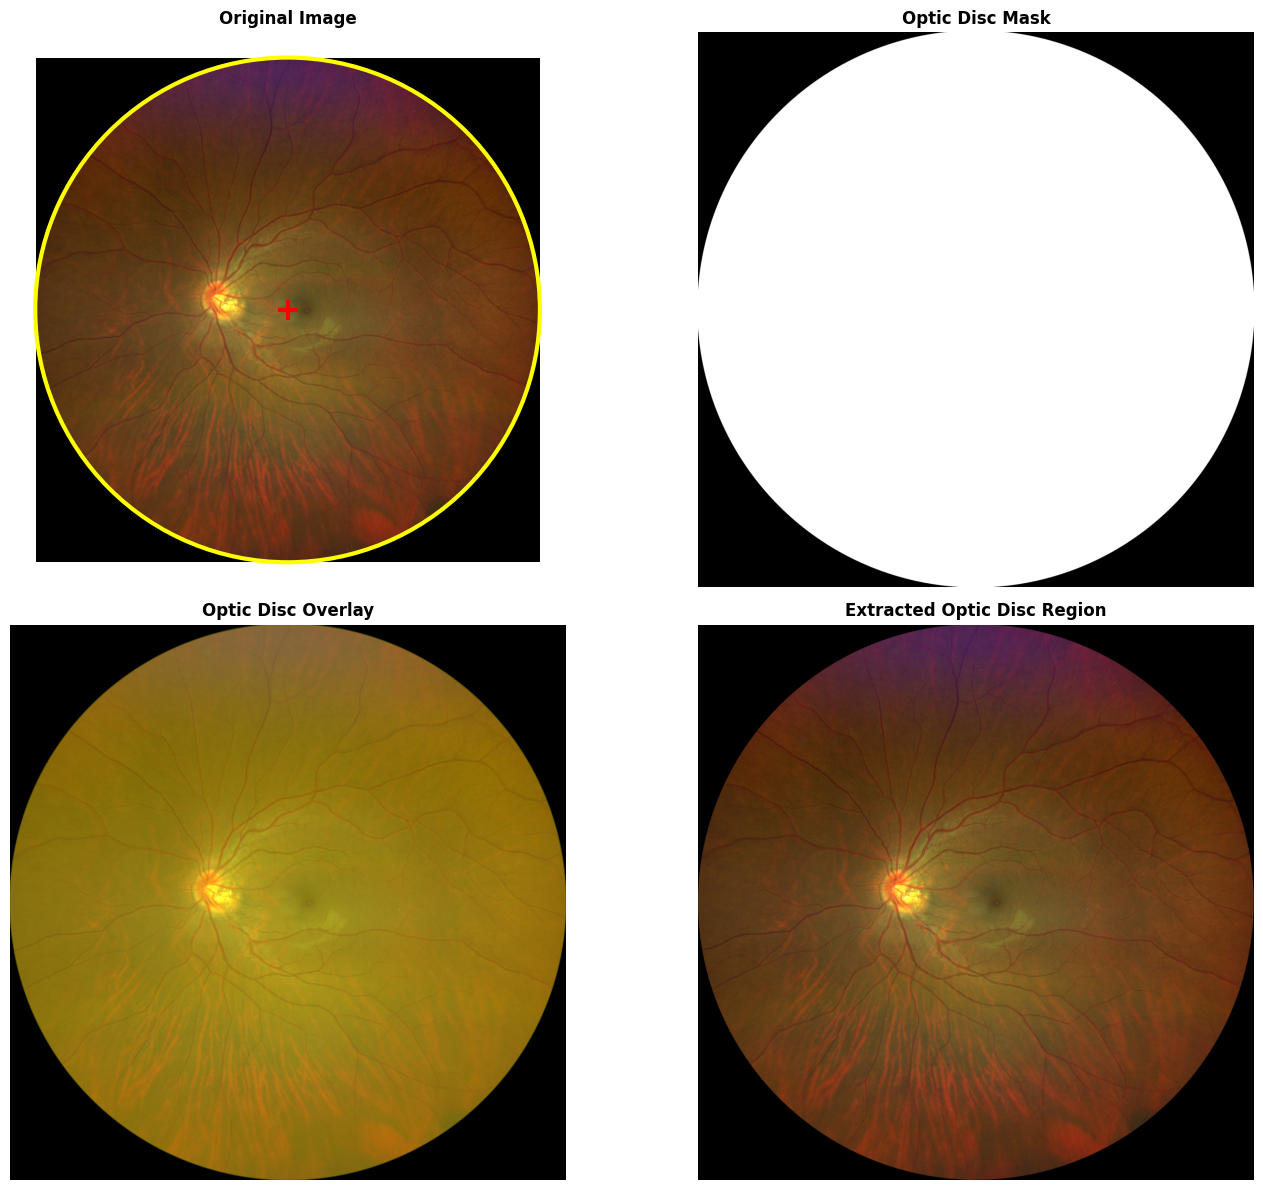

Optic Disc Center: (1955, 1955)
Optic Disc Radius: 1960 pixels
Optic Disc Area: 12068742.34 square pixels


In [22]:
def detect_optic_disc(img_rgb, img_gray):
    """Detect and segment the optic disc"""
    # Convert to different color spaces
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    # Optic disc is typically bright yellow/orange
    # Use value channel (brightness) for detection
    value_channel = hsv[:, :, 2]

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(value_channel, (15, 15), 0)

    # Threshold to find bright regions
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations to clean up
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None, None, None

    # Find the largest contour (likely the optic disc)
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate center and radius
    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
    center = (int(x), int(y))
    radius = int(radius)

    # Create mask
    mask = np.zeros(img_gray.shape, dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, -1)

    return center, radius, mask

def segment_optic_disc_region(img_rgb, center, radius):
    """Extract the optic disc region"""
    if center is None:
        return None

    # Create circular mask
    mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
    cv2.circle(mask, center, int(radius * 1.2), 255, -1)

    # Extract region
    optic_disc_region = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

    return optic_disc_region, mask

# Detect optic disc
center, radius, disc_mask = detect_optic_disc(sample_rgb, sample_gray)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].imshow(sample_rgb)
axes[0, 0].set_title("Original Image", fontsize=12, fontweight='bold')
axes[0, 0].axis('off')
if center is not None:
    circle = Circle(center, radius, fill=False, edgecolor='yellow', linewidth=3)
    axes[0, 0].add_patch(circle)
    axes[0, 0].plot(center[0], center[1], 'r+', markersize=15, markeredgewidth=3)

axes[0, 1].imshow(disc_mask, cmap='gray')
axes[0, 1].set_title("Optic Disc Mask", fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# Overlay on original
overlay = sample_rgb.copy()
if center is not None:
    overlay[disc_mask > 0] = [255, 255, 0]  # Yellow overlay
    blended = cv2.addWeighted(sample_rgb, 0.7, overlay, 0.3, 0)
    axes[1, 0].imshow(blended)
    axes[1, 0].set_title("Optic Disc Overlay", fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')

# Extract optic disc region
if center is not None:
    disc_region, _ = segment_optic_disc_region(sample_rgb, center, radius)
    axes[1, 1].imshow(disc_region)
    axes[1, 1].set_title("Extracted Optic Disc Region", fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

if center is not None:
    print(f"Optic Disc Center: {center}")
    print(f"Optic Disc Radius: {radius} pixels")
    print(f"Optic Disc Area: {np.pi * radius**2:.2f} square pixels")


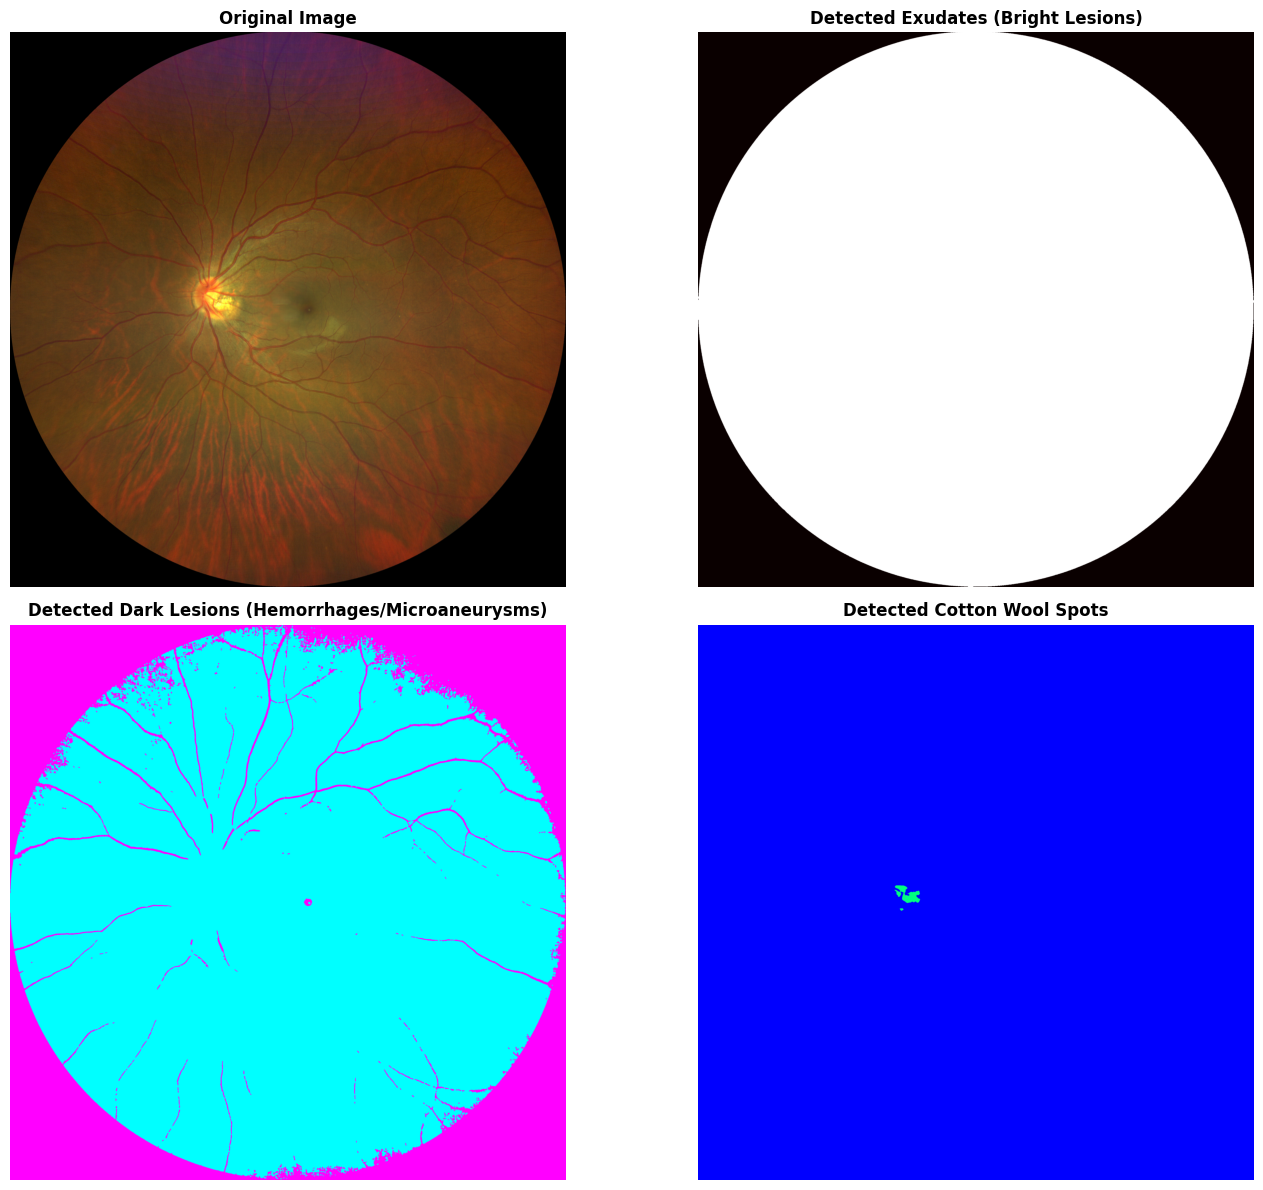

Detected 1 exudate regions
Detected 421 dark lesion regions
Detected 2 cotton wool spot regions


In [24]:
def detect_exudates(img_rgb):
    """Detect bright exudates (yellow-white lesions)"""
    # Convert to LAB color space
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l_channel = lab[:, :, 0]  # Lightness channel

    # Exudates are bright, so use high threshold on L channel
    _, binary = cv2.threshold(l_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Remove small objects
    binary = remove_small_objects(binary.astype(bool), min_size=100).astype(np.uint8) * 255

    return binary

def detect_dark_lesions(img_rgb):
    """Detect dark lesions (hemorrhages, microaneurysms)"""
    # Use green channel
    green = extract_green_channel(img_rgb)
    enhanced = enhance_contrast(green)

    # Invert for dark lesion detection
    inverted = 255 - enhanced

    # Threshold
    threshold = filters.threshold_otsu(inverted)
    binary = inverted > threshold

    # Morphological operations
    binary = morphology.binary_closing(binary, morphology.disk(3))
    binary = morphology.binary_opening(binary, morphology.disk(2))

    # Remove small objects
    binary = remove_small_objects(binary, min_size=50)

    return binary.astype(np.uint8) * 255

def detect_cotton_wool_spots(img_rgb):
    """Detect cotton wool spots (fluffy white patches)"""
    # Convert to grayscale
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)

    # High threshold for bright regions
    _, binary = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)

    # Morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Remove small objects
    binary = remove_small_objects(binary.astype(bool), min_size=200).astype(np.uint8) * 255

    return binary

# Detect various lesions
exudates = detect_exudates(sample_rgb)
dark_lesions = detect_dark_lesions(sample_rgb)
cotton_wool = detect_cotton_wool_spots(sample_rgb)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].imshow(sample_rgb)
axes[0, 0].set_title("Original Image", fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(exudates, cmap='hot')
axes[0, 1].set_title("Detected Exudates (Bright Lesions)", fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[1, 0].imshow(dark_lesions, cmap='cool')
axes[1, 0].set_title("Detected Dark Lesions (Hemorrhages/Microaneurysms)", fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(cotton_wool, cmap='winter')
axes[1, 1].set_title("Detected Cotton Wool Spots", fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Count lesions
exudate_count = len(measure.regionprops(measure.label(exudates > 0)))
dark_lesion_count = len(measure.regionprops(measure.label(dark_lesions > 0)))
cotton_wool_count = len(measure.regionprops(measure.label(cotton_wool > 0)))

print(f"Detected {exudate_count} exudate regions")
print(f"Detected {dark_lesion_count} dark lesion regions")
print(f"Detected {cotton_wool_count} cotton wool spot regions")


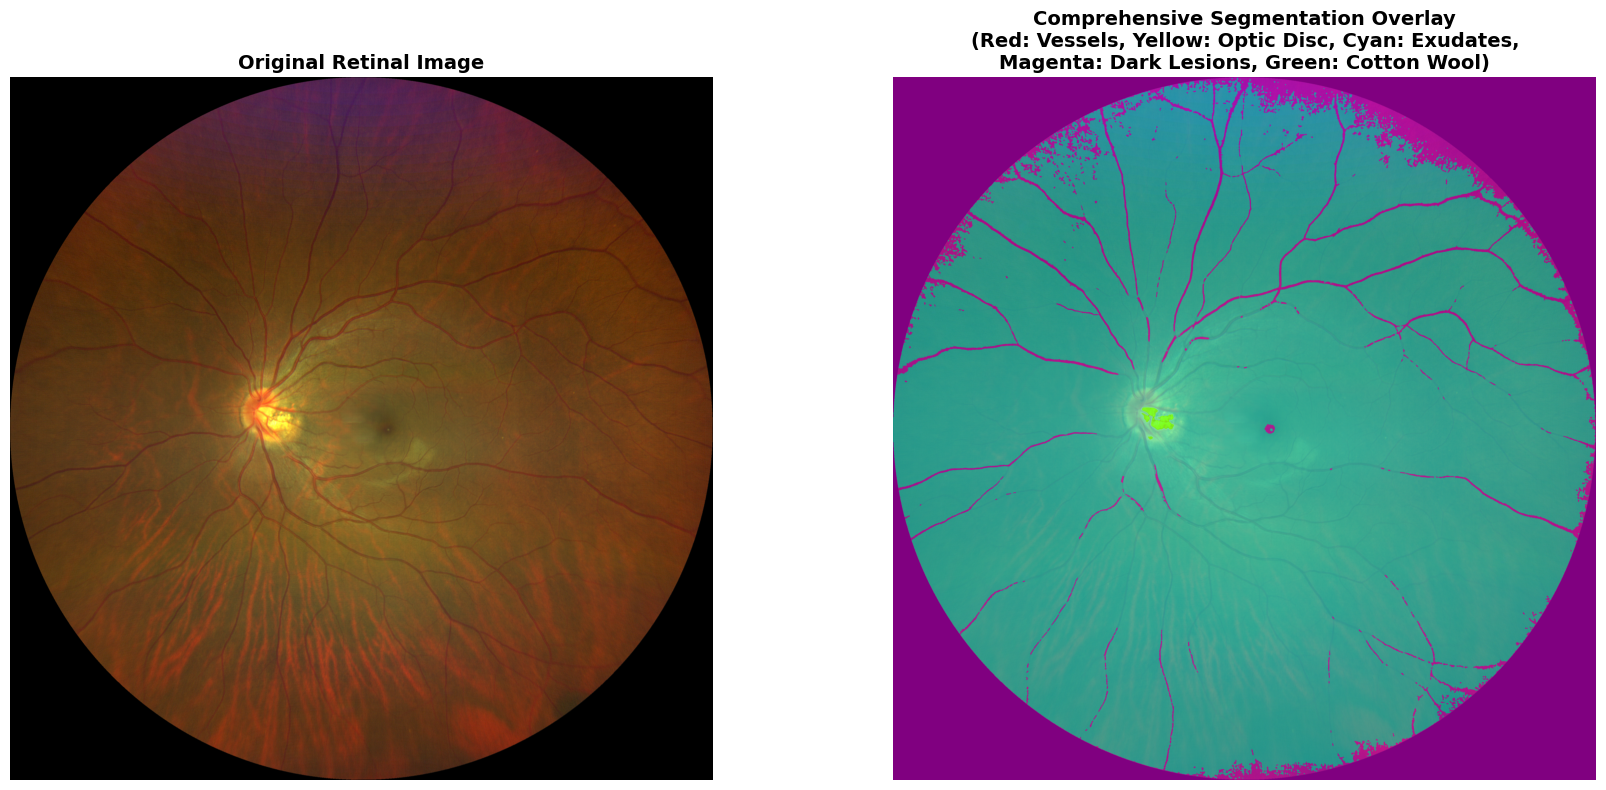

In [25]:
def comprehensive_segmentation(img_rgb, img_gray):
    """Perform comprehensive segmentation of all retinal structures"""
    results = {}

    # Vessel segmentation
    results['vessels'] = segment_vessels_morphological(img_gray)

    # Optic disc detection
    center, radius, disc_mask = detect_optic_disc(img_rgb, img_gray)
    results['optic_disc'] = {'center': center, 'radius': radius, 'mask': disc_mask}

    # Lesion detection
    results['exudates'] = detect_exudates(img_rgb)
    results['dark_lesions'] = detect_dark_lesions(img_rgb)
    results['cotton_wool'] = detect_cotton_wool_spots(img_rgb)

    return results

def create_overlay_visualization(img_rgb, segmentation_results):
    """Create a comprehensive overlay visualization"""
    overlay = img_rgb.copy()

    # Color coding:
    # Vessels: Red
    # Optic disc: Yellow
    # Exudates: Cyan
    # Dark lesions: Magenta
    # Cotton wool: Green

    # Overlay vessels (red)
    vessels_mask = segmentation_results['vessels'] > 0
    overlay[vessels_mask] = [255, 0, 0]

    # Overlay optic disc (yellow)
    if segmentation_results['optic_disc']['mask'] is not None:
        disc_mask = segmentation_results['optic_disc']['mask'] > 0
        overlay[disc_mask] = [255, 255, 0]

    # Overlay exudates (cyan)
    exudates_mask = segmentation_results['exudates'] > 0
    overlay[exudates_mask] = [0, 255, 255]

    # Overlay dark lesions (magenta)
    dark_mask = segmentation_results['dark_lesions'] > 0
    overlay[dark_mask] = [255, 0, 255]

    # Overlay cotton wool (green)
    cotton_mask = segmentation_results['cotton_wool'] > 0
    overlay[cotton_mask] = [0, 255, 0]

    # Blend with original
    blended = cv2.addWeighted(img_rgb, 0.5, overlay, 0.5, 0)

    return blended

# Perform comprehensive segmentation
seg_results = comprehensive_segmentation(sample_rgb, sample_gray)

# Create overlay visualization
overlay_img = create_overlay_visualization(sample_rgb, seg_results)

# Display comprehensive results
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

axes[0].imshow(sample_rgb)
axes[0].set_title("Original Retinal Image", fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(overlay_img)
axes[1].set_title("Comprehensive Segmentation Overlay\n(Red: Vessels, Yellow: Optic Disc, Cyan: Exudates,\nMagenta: Dark Lesions, Green: Cotton Wool)",
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [26]:
def calculate_screening_metrics(img_rgb, segmentation_results):
    """Calculate metrics for disease screening"""
    metrics = {}

    # Vessel density (percentage of image covered by vessels)
    vessel_pixels = np.sum(segmentation_results['vessels'] > 0)
    total_pixels = segmentation_results['vessels'].size
    metrics['vessel_density'] = (vessel_pixels / total_pixels) * 100

    # Optic disc metrics
    if segmentation_results['optic_disc']['center'] is not None:
        disc_radius = segmentation_results['optic_disc']['radius']
        disc_area = np.pi * disc_radius**2
        metrics['optic_disc_area'] = disc_area
        metrics['optic_disc_radius'] = disc_radius
        metrics['optic_disc_area_percentage'] = (disc_area / total_pixels) * 100
    else:
        metrics['optic_disc_area'] = None
        metrics['optic_disc_radius'] = None
        metrics['optic_disc_area_percentage'] = None

    # Lesion metrics
    exudate_pixels = np.sum(segmentation_results['exudates'] > 0)
    metrics['exudate_area'] = exudate_pixels
    metrics['exudate_percentage'] = (exudate_pixels / total_pixels) * 100
    metrics['exudate_count'] = len(measure.regionprops(measure.label(segmentation_results['exudates'] > 0)))

    dark_lesion_pixels = np.sum(segmentation_results['dark_lesions'] > 0)
    metrics['dark_lesion_area'] = dark_lesion_pixels
    metrics['dark_lesion_percentage'] = (dark_lesion_pixels / total_pixels) * 100
    metrics['dark_lesion_count'] = len(measure.regionprops(measure.label(segmentation_results['dark_lesions'] > 0)))

    cotton_wool_pixels = np.sum(segmentation_results['cotton_wool'] > 0)
    metrics['cotton_wool_area'] = cotton_wool_pixels
    metrics['cotton_wool_percentage'] = (cotton_wool_pixels / total_pixels) * 100
    metrics['cotton_wool_count'] = len(measure.regionprops(measure.label(segmentation_results['cotton_wool'] > 0)))

    # Total abnormality score (weighted combination)
    total_abnormality = (metrics['exudate_percentage'] * 2.0 +
                        metrics['dark_lesion_percentage'] * 1.5 +
                        metrics['cotton_wool_percentage'] * 1.0)
    metrics['total_abnormality_score'] = total_abnormality

    # Risk assessment (simplified)
    if total_abnormality > 5.0:
        metrics['risk_level'] = 'High'
    elif total_abnormality > 2.0:
        metrics['risk_level'] = 'Medium'
    else:
        metrics['risk_level'] = 'Low'

    return metrics

# Calculate metrics for sample image
sample_metrics = calculate_screening_metrics(sample_rgb, seg_results)

# Display metrics
print("=" * 60)
print("DISEASE SCREENING METRICS")
print("=" * 60)
print(f"\nVessel Analysis:")
print(f"  - Vessel Density: {sample_metrics['vessel_density']:.2f}%")

print(f"\nOptic Disc Analysis:")
if sample_metrics['optic_disc_radius'] is not None:
    print(f"  - Optic Disc Radius: {sample_metrics['optic_disc_radius']:.2f} pixels")
    print(f"  - Optic Disc Area: {sample_metrics['optic_disc_area']:.2f} square pixels")
    print(f"  - Optic Disc Area Percentage: {sample_metrics['optic_disc_area_percentage']:.2f}%")
else:
    print("  - Optic disc not detected")

print(f"\nLesion Analysis:")
print(f"  - Exudates:")
print(f"    * Count: {sample_metrics['exudate_count']}")
print(f"    * Area: {sample_metrics['exudate_area']} pixels ({sample_metrics['exudate_percentage']:.2f}%)")
print(f"  - Dark Lesions (Hemorrhages/Microaneurysms):")
print(f"    * Count: {sample_metrics['dark_lesion_count']}")
print(f"    * Area: {sample_metrics['dark_lesion_area']} pixels ({sample_metrics['dark_lesion_percentage']:.2f}%)")
print(f"  - Cotton Wool Spots:")
print(f"    * Count: {sample_metrics['cotton_wool_count']}")
print(f"    * Area: {sample_metrics['cotton_wool_area']} pixels ({sample_metrics['cotton_wool_percentage']:.2f}%)")

print(f"\nOverall Assessment:")
print(f"  - Total Abnormality Score: {sample_metrics['total_abnormality_score']:.2f}")
print(f"  - Risk Level: {sample_metrics['risk_level']}")
print("=" * 60)


DISEASE SCREENING METRICS

Vessel Analysis:
  - Vessel Density: 76.30%

Optic Disc Analysis:
  - Optic Disc Radius: 1960.00 pixels
  - Optic Disc Area: 12068742.34 square pixels
  - Optic Disc Area Percentage: 78.86%

Lesion Analysis:
  - Exudates:
    * Count: 1
    * Area: 11998473 pixels (78.40%)
  - Dark Lesions (Hemorrhages/Microaneurysms):
    * Count: 421
    * Area: 3934175 pixels (25.71%)
  - Cotton Wool Spots:
    * Count: 2
    * Area: 11713 pixels (0.08%)

Overall Assessment:
  - Total Abnormality Score: 195.44
  - Risk Level: High


In [27]:
# Process all images
all_metrics = []

print("Processing all retinal images...")
print("-" * 60)

for idx, img_file in enumerate(image_files, 1):
    try:
        img_path = Path(data_dir) / img_file
        img_rgb, img_gray = load_retinal_image(img_path)

        # Perform segmentation
        seg_results = comprehensive_segmentation(img_rgb, img_gray)

        # Calculate metrics
        metrics = calculate_screening_metrics(img_rgb, seg_results)
        metrics['image_name'] = img_file

        all_metrics.append(metrics)

        print(f"[{idx}/{len(image_files)}] Processed: {img_file} - Risk: {metrics['risk_level']}")

    except Exception as e:
        print(f"[{idx}/{len(image_files)}] Error processing {img_file}: {str(e)}")
        continue

print("-" * 60)
print(f"Successfully processed {len(all_metrics)} images")

Processing all retinal images...
------------------------------------------------------------
[1/123] Processed: TJDR_train_001.png - Risk: High
[2/123] Processed: TJDR_train_003.png - Risk: High
[3/123] Processed: TJDR_train_013.png - Risk: High
[4/123] Processed: TJDR_train_017.png - Risk: High
[5/123] Processed: TJDR_train_021.png - Risk: High
[6/123] Processed: TJDR_train_023.png - Risk: High
[7/123] Processed: TJDR_train_032.png - Risk: High
[8/123] Processed: TJDR_train_035.png - Risk: High
[9/123] Processed: TJDR_train_048.png - Risk: High
[10/123] Processed: TJDR_train_049.png - Risk: High
[11/123] Processed: TJDR_train_050.png - Risk: High
[12/123] Processed: TJDR_train_053.png - Risk: High
[13/123] Processed: TJDR_train_057.png - Risk: High
[14/123] Processed: TJDR_train_064.png - Risk: High
[15/123] Processed: TJDR_train_072.png - Risk: High
[16/123] Processed: TJDR_train_074.png - Risk: High
[17/123] Processed: TJDR_train_079.png - Risk: High
[18/123] Processed: TJDR_train_

In [28]:
# Create summary statistics
import pandas as pd

# Convert to DataFrame for easier analysis
df_metrics = pd.DataFrame(all_metrics)

# Display summary statistics
print("\n" + "=" * 60)
print("SUMMARY STATISTICS - ALL IMAGES")
print("=" * 60)

print("\nVessel Density Statistics:")
print(df_metrics['vessel_density'].describe())

print("\nOptic Disc Statistics:")
optic_disc_radii = df_metrics['optic_disc_radius'].dropna()
if len(optic_disc_radii) > 0:
    print(optic_disc_radii.describe())
else:
    print("  No optic discs detected in any images")

print("\nLesion Statistics:")
print(f"  Exudates - Mean Count: {df_metrics['exudate_count'].mean():.2f}")
print(f"  Dark Lesions - Mean Count: {df_metrics['dark_lesion_count'].mean():.2f}")
print(f"  Cotton Wool Spots - Mean Count: {df_metrics['cotton_wool_count'].mean():.2f}")

print("\nRisk Level Distribution:")
risk_distribution = df_metrics['risk_level'].value_counts()
print(risk_distribution)

print("\nAbnormality Score Statistics:")
print(df_metrics['total_abnormality_score'].describe())

print("=" * 60)


SUMMARY STATISTICS - ALL IMAGES

Vessel Density Statistics:
count    123.000000
mean      66.527881
std       11.163653
min       10.899734
25%       56.657052
50%       73.159836
75%       76.273594
max       77.359985
Name: vessel_density, dtype: float64

Optic Disc Statistics:
count     123.000000
mean     1519.024390
std       464.371221
min      1024.000000
25%      1030.000000
50%      1948.000000
75%      1960.000000
max      1961.000000
Name: optic_disc_radius, dtype: float64

Lesion Statistics:
  Exudates - Mean Count: 13.05
  Dark Lesions - Mean Count: 296.50
  Cotton Wool Spots - Mean Count: 1.98

Risk Level Distribution:
risk_level
High    123
Name: count, dtype: int64

Abnormality Score Statistics:
count    123.000000
mean     194.756757
std       11.113794
min      151.027048
25%      191.396578
50%      194.251597
75%      197.658491
max      244.297147
Name: total_abnormality_score, dtype: float64


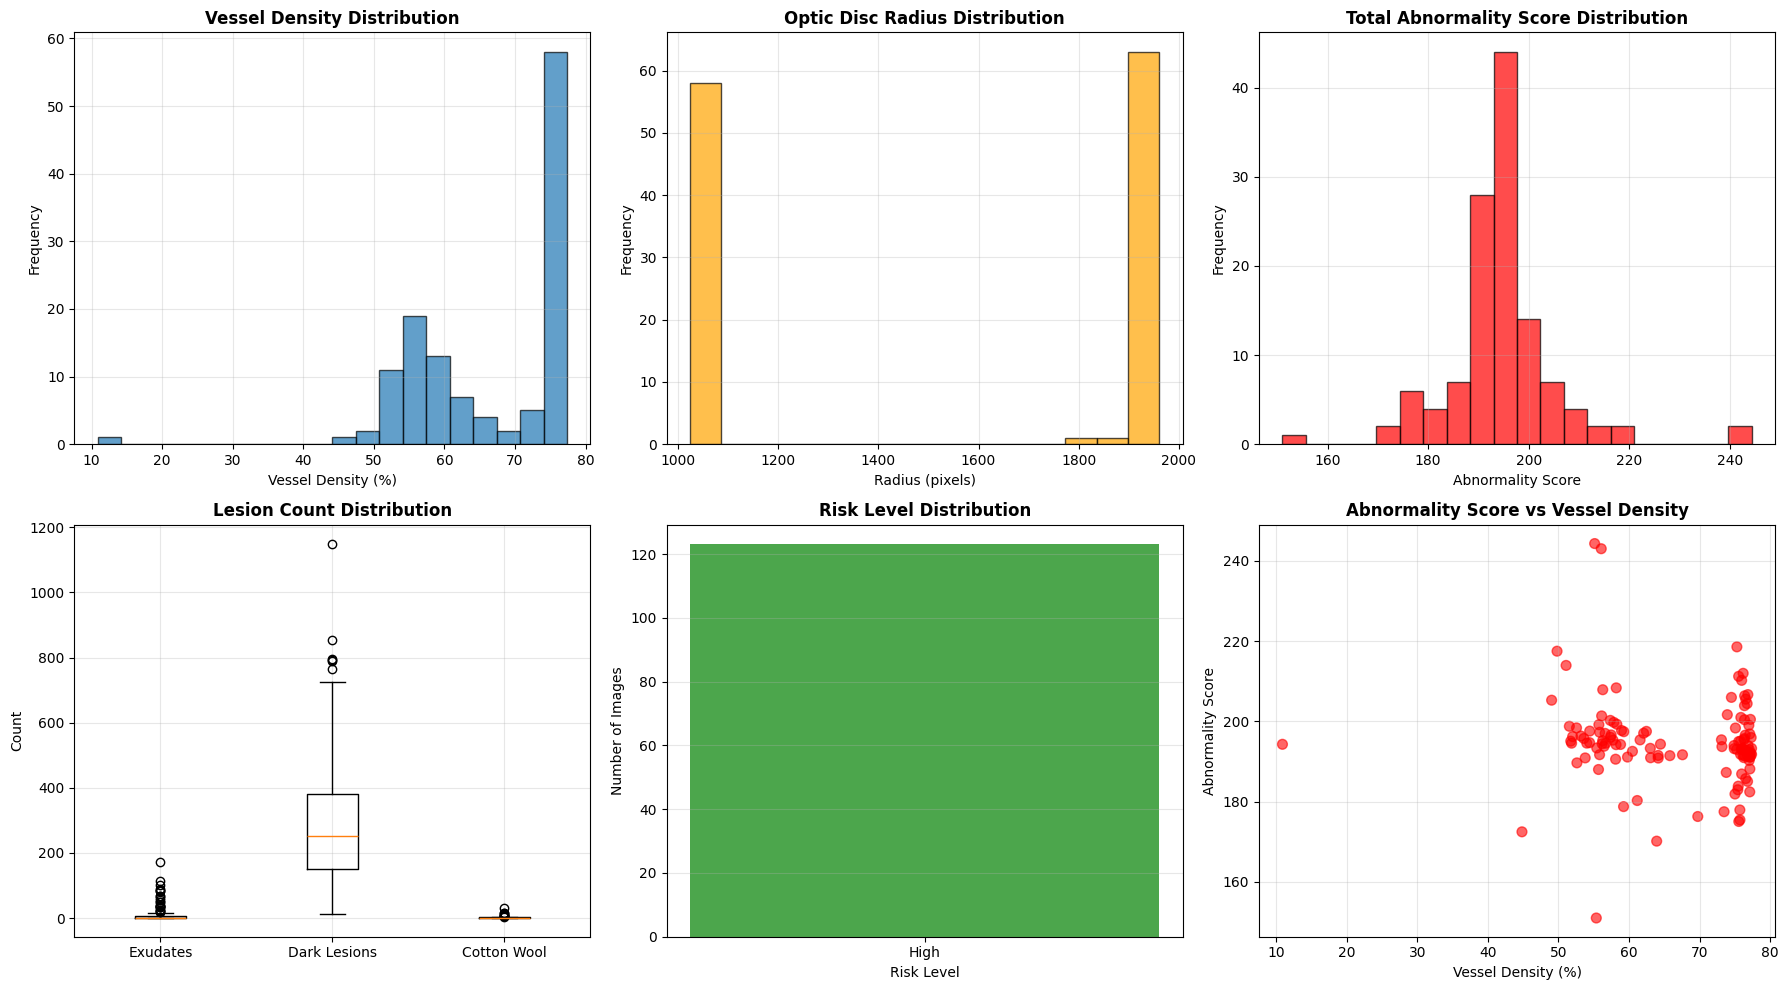

In [29]:
# Visualize distribution of metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Vessel density distribution
axes[0, 0].hist(df_metrics['vessel_density'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Vessel Density Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Vessel Density (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Optic disc radius distribution
optic_disc_radii = df_metrics['optic_disc_radius'].dropna()
if len(optic_disc_radii) > 0:
    axes[0, 1].hist(optic_disc_radii, bins=15, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].set_title('Optic Disc Radius Distribution', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Radius (pixels)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)

# Abnormality score distribution
axes[0, 2].hist(df_metrics['total_abnormality_score'], bins=20, edgecolor='black', alpha=0.7, color='red')
axes[0, 2].set_title('Total Abnormality Score Distribution', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Abnormality Score')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(True, alpha=0.3)

# Lesion counts
lesion_data = {
    'Exudates': df_metrics['exudate_count'],
    'Dark Lesions': df_metrics['dark_lesion_count'],
    'Cotton Wool': df_metrics['cotton_wool_count']
}
axes[1, 0].boxplot(lesion_data.values(), labels=lesion_data.keys())
axes[1, 0].set_title('Lesion Count Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Count')
axes[1, 0].grid(True, alpha=0.3)

# Risk level distribution
risk_counts = df_metrics['risk_level'].value_counts()
axes[1, 1].bar(risk_counts.index, risk_counts.values, color=['green', 'orange', 'red'], alpha=0.7)
axes[1, 1].set_title('Risk Level Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Risk Level')
axes[1, 1].set_ylabel('Number of Images')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Scatter plot: Abnormality vs Vessel Density
axes[1, 2].scatter(df_metrics['vessel_density'], df_metrics['total_abnormality_score'],
                   c=df_metrics['risk_level'].map({'Low': 'green', 'Medium': 'orange', 'High': 'red'}),
                   alpha=0.6, s=50)
axes[1, 2].set_title('Abnormality Score vs Vessel Density', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Vessel Density (%)')
axes[1, 2].set_ylabel('Abnormality Score')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Found 123 high-risk images:
        image_name  total_abnormality_score risk_level
TJDR_train_385.png               244.297147       High
TJDR_train_318.png               243.010175       High
TJDR_train_151.png               218.564189       High
TJDR_train_399.png               217.487991       High
TJDR_train_332.png               213.942564       High
TJDR_train_140.png               211.973541       High
TJDR_train_064.png               211.224185       High
TJDR_train_099.png               210.221799       High
TJDR_train_375.png               208.352900       High
TJDR_train_299.png               207.890058       High
TJDR_train_170.png               206.677441       High
TJDR_train_013.png               206.373418       High
TJDR_train_158.png               205.980177       High
TJDR_train_203.png               205.532512       High
TJDR_train_413.png               205.278528       High
TJDR_train_072.png               204.433709       High
TJDR_train_143.png               203.

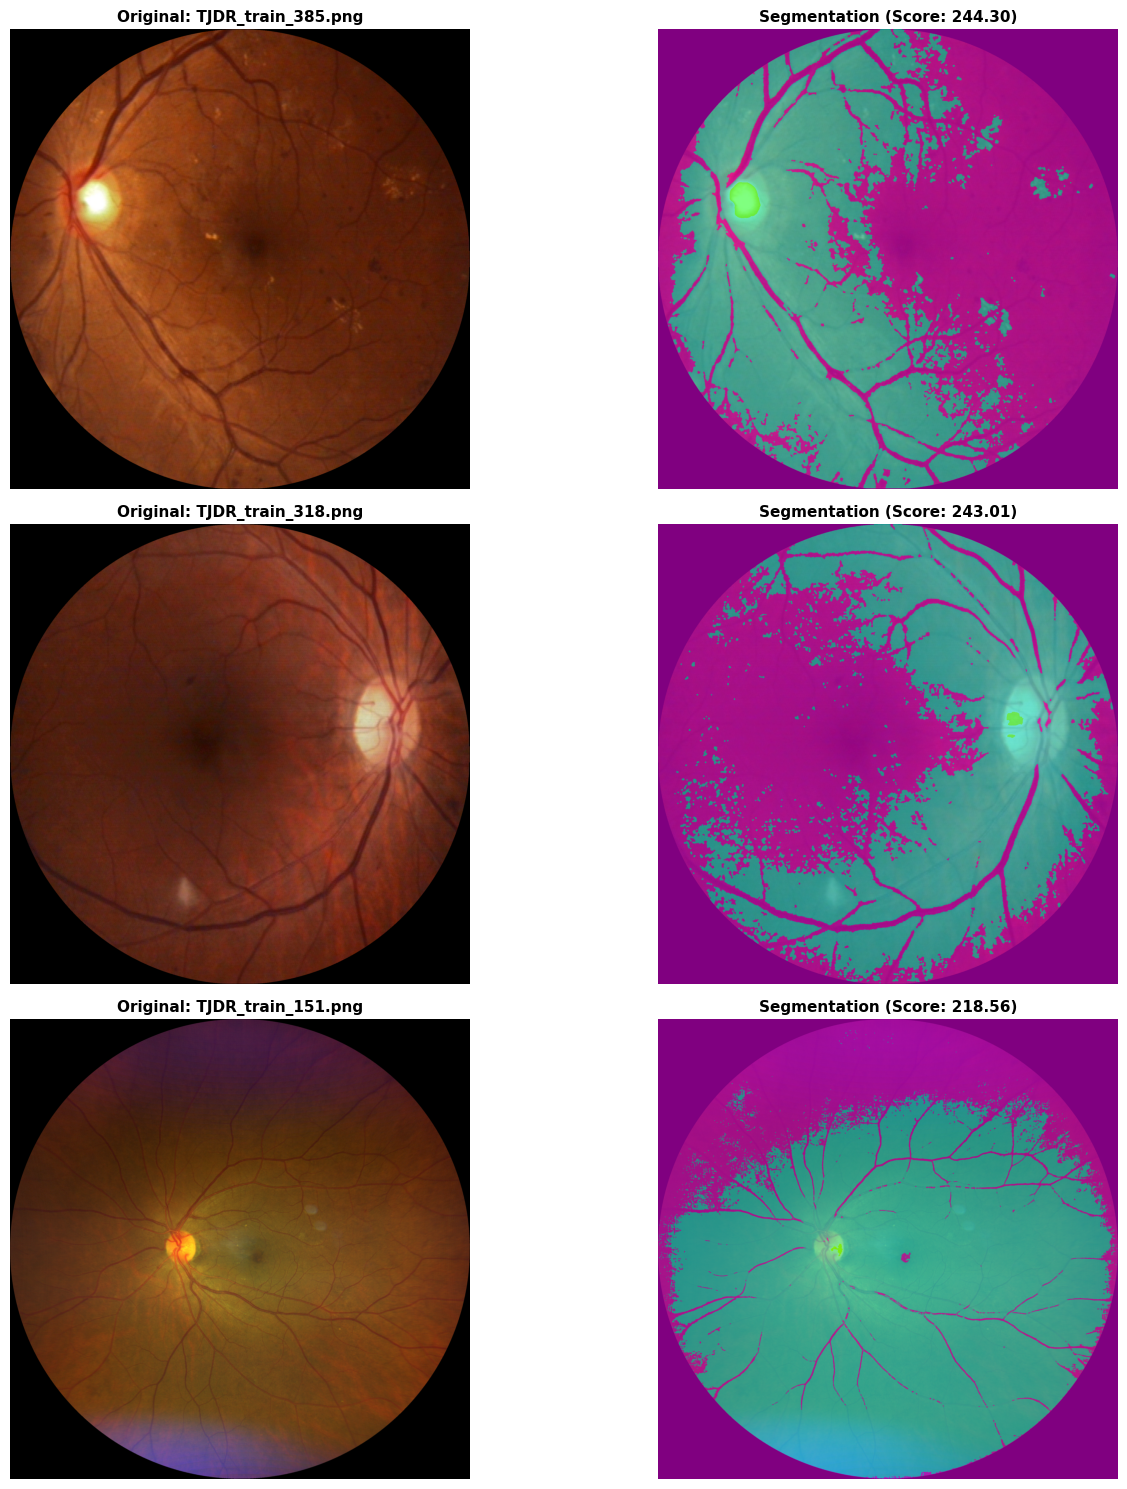

In [30]:
# Find high-risk images
high_risk_images = df_metrics[df_metrics['risk_level'] == 'High'].sort_values(
    'total_abnormality_score', ascending=False
)

if len(high_risk_images) > 0:
    print(f"Found {len(high_risk_images)} high-risk images:")
    print(high_risk_images[['image_name', 'total_abnormality_score', 'risk_level']].to_string(index=False))

    # Visualize top high-risk images
    num_to_show = min(3, len(high_risk_images))
    fig, axes = plt.subplots(num_to_show, 2, figsize=(15, 5*num_to_show))

    if num_to_show == 1:
        axes = axes.reshape(1, -1)

    for idx, (_, row) in enumerate(high_risk_images.head(num_to_show).iterrows()):
        img_path = Path(data_dir) / row['image_name']
        img_rgb, img_gray = load_retinal_image(img_path)
        seg_results = comprehensive_segmentation(img_rgb, img_gray)
        overlay_img = create_overlay_visualization(img_rgb, seg_results)

        axes[idx, 0].imshow(img_rgb)
        axes[idx, 0].set_title(f"Original: {row['image_name']}", fontsize=11, fontweight='bold')
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(overlay_img)
        axes[idx, 1].set_title(f"Segmentation (Score: {row['total_abnormality_score']:.2f})",
                              fontsize=11, fontweight='bold')
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No high-risk images found in the dataset.")

In [31]:
# Export results to CSV
output_file = 'retinal_segmentation_results.csv'
df_metrics.to_csv(output_file, index=False)
print(f"Results exported to: {output_file}")

# Display first few rows
print("\nFirst 5 rows of results:")
print(df_metrics.head().to_string(index=False))

Results exported to: retinal_segmentation_results.csv

First 5 rows of results:
 vessel_density  optic_disc_area  optic_disc_radius  optic_disc_area_percentage  exudate_area  exudate_percentage  exudate_count  dark_lesion_area  dark_lesion_percentage  dark_lesion_count  cotton_wool_area  cotton_wool_percentage  cotton_wool_count  total_abnormality_score risk_level         image_name
      76.296251     1.206874e+07               1960                   78.861371      11998473           78.402207              1           3934175               25.707271                421             11713                0.076537                  2               195.441857       High TJDR_train_001.png
      75.925042     1.206874e+07               1960                   78.861371      11997825           78.397972              1           3704869               24.208906                308             12078                0.078922                  1               193.188226       High TJDR_train_003.png
  